In [2]:
# Sobre el dataset 'California housing', realiza un modelo de regresión LASSO de la mediana de los valores de las casas (Y-respuesta) con las
# variables restantes, numéricas y categóricas, del dataset.
# a) Con el parámetro de encogimiento alpha=1.
# b) Con el parámetro de encogimiento alpha=10^4.
# c) Compara ambos modelos con el modelo de regresión lineal múltiple. ¿Qué se observa?

In [12]:
# Apartado a)
# Se comienza al igual que en el ejercicio 6.1. Primero se carga el dataset, luego se separa la variable respuesta de las predictoras. Entre las 
# variables predictoras se separa entre categóricas y numéricas. Se lleva a cabo imputación, seguido de estandarización, mediante la clase Pipeline
# de las variables numéricas. Se crea variable indicadora asocidada a la variable categórica mediante la clase OneHotEncoder. Finalmente, se juntan
# variables numéricas con la categórica, de nuevo, mediante la clase ColumnTransformer.

import pandas as pd
from sklearn.impute import SimpleImputer # Para imputación
from sklearn.preprocessing import StandardScaler # Para estandarización
from sklearn.pipeline import Pipeline # Para combinar imputación y estandarización
from sklearn.preprocessing import OneHotEncoder # Para crear variable indicadora
from sklearn.compose import ColumnTransformer # Para considerar la variable categórica en la imputación y estandarización

housing = pd.read_csv('datasets/housing/housing.csv')

# Variable respuesta
respuesta = housing['median_house_value'].copy()
housing = housing.drop('median_house_value', axis=1)

# Variables numéricas
housing_num = housing.drop('ocean_proximity', axis=1)

# Imputación y estandarización de las variables numéricas
num_pipeline = Pipeline([
    ('imputador', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num) # Se aplica pipeline

# Nombre de variables numéricas
num_attribs = list(housing_num)

# Nombre de variable categórica
cat_attribs = ['ocean_proximity']

# Se añade la variable categórica al proceso de imputación y estandarización. Se añade una de las variables categóricas en el intercepto 
# (drop='first')
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(drop='first'), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing) # Se aplica pipeline

In [18]:
# Ahora ya se puede realizar la regresión LASSO. Para ello se emplea la clase Lasso de la librería 'sklearn'.
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=1)
lasso_reg.fit(housing_prepared, respuesta)

print('Coeficientes del modelo de regresión LASSO:')
print('Intercepto:', lasso_reg.intercept_)
print('Beta:', lasso_reg.coef_)

Coeficientes del modelo de regresión LASSO:
Intercepto: 219239.371611401
Beta: [-52936.10528879 -53753.78630134  13312.79044653 -10299.69365603
  29909.69564186 -44483.79617817  29730.65349082  73630.76579416
 -39774.84408823 151938.98956871  -3679.84442713   4753.79358651]


In [21]:
# alpha = 1 no aplica apenas penalización y los resultados obtenidos son prácticamente los mismos que se obtenían en el ejercicio 5.2.

In [26]:
# Apartado b)
# Se toma ahora alpha = 10^4.

lasso_reg_b = Lasso(alpha=1e4)
lasso_reg_b.fit(housing_prepared, respuesta)

print('Coeficientes del modelo de regresión LASSO:')
print('Intercepto:', lasso_reg_b.intercept_)
print('Beta:', lasso_reg_b.coef_)

Coeficientes del modelo de regresión LASSO:
Intercepto: 218717.12395482304
Beta: [    -0.             -0.           5925.06123247      0.
      0.             -0.              0.          65973.15122729
 -37370.99334873      0.              0.              0.        ]


In [28]:
# Muchos coeficientes son ahora cero, lo cual permite considerarlas como variables no significativas en ausencia de colinealidad.

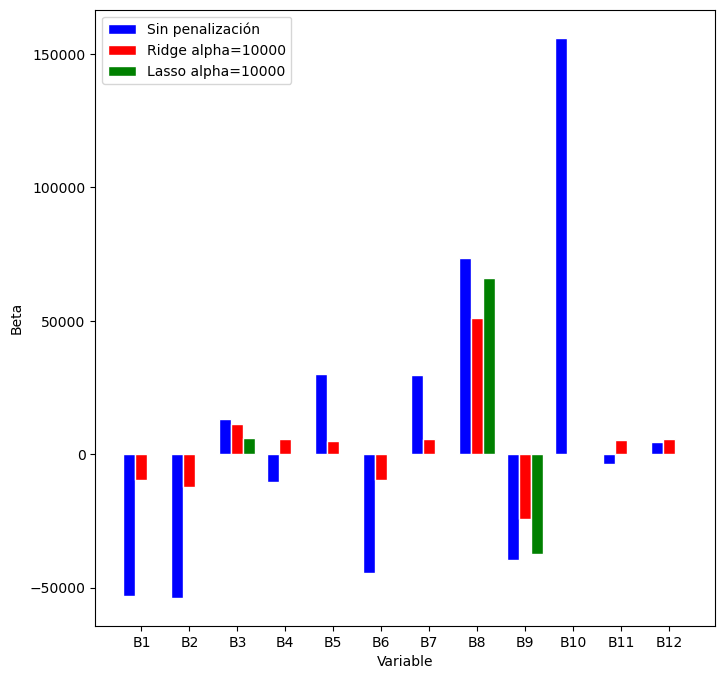

In [34]:
# Apartado c)
# Comparamos los resultados del apartado b  con aquellos proporcionados por el modelo de regresión lineal múltiple no penalizado y la regresión Ridge.
# Para ello, empezamos construyendo el modelo sin penalizar. La comparación se muestra en un diagrama de barras.

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge

# Modelo sin penalizar
lm = LinearRegression()
lm.fit(housing_prepared, respuesta)

# Modelo de regresión Ridge (apartado b del ejercicio 6.1.)
ridge_reg = Ridge(alpha=1e4, solver='auto')
ridge_reg.fit(housing_prepared, respuesta)

# Representación gráfica
barWidth = 0.25 # Ancho barras
r1 = np.arange(len(lm.coef_)) # Array [0, 1, 2, ..., len(lm.coef_)-1] para ubicar las barras en el diagrama
r2 = [x + barWidth for x in r1] # Ubicación de las barras correspondientes a la regresión Ridge
r3 = [x + barWidth for x in r2] # Ubicación de las barras correspondientes a la regresión LASSO
fig = plt.figure(figsize=(8,8))
plt.bar(r1, lm.coef_, color='blue', width=barWidth, edgecolor='white', label='Sin penalización')
plt.bar(r2, ridge_reg.coef_, color='red', width=barWidth, edgecolor='white', label='Ridge alpha=10000')
plt.bar(r3, lasso_reg_b.coef_, color='green', width=barWidth, edgecolor='white', label='Lasso alpha=10000')
plt.xticks([x + barWidth for x in range(len(lm.coef_))],
          ['B'+str(i) for i in range(1,13)])
plt.legend()
plt.xlabel('Variable')
plt.ylabel('Beta')
plt.show(fig)

In [36]:
# Es importante notar que, aunque para la regresión LASSO desaparezcan algunas variables, en otras se estima un coeficiente más alto que el
# correspondiente obtenido mediante Ridge y casi tan alto como el que predice el modelo sin penalización. Esto es debido a que cuando dos variables
# están correlacionadas, la regresión LASSO tiende a descartar una variable y a ajustar la otra. 